<a href="https://www.kaggle.com/code/abd0kamel/mutemotion-asl-citizen-translation-model?scriptVersionId=162008209" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div id="Introduction">
    
# **Introduction**

<h3> This notebook aims to use MediaPipe landmarks detection as the starting point
    
<h3> for building an American Sign Language Translation Model using <b>ASL Citizen</b> Dataset
            
**<h3> Sections:**
* [Importing Libraries](#Importing_Libraries)
* [Data Preparation](#Data_Preparation)
* [MediaPipe Implementation](#MediaPipe_Implementation)
* [Visualizing Landmarks](#Visualizing_Landmarks)
* [Data Encoding](#Data_Encoding)
* [Label Filtering](#Label_Filtering)
* [Data Loading](#Data_Loading) --> (Training Start Here)
* [Data Augmentation](#Data_Augmentation)
* [Data Preprocessing](#Data_Preprocessing)
* [Label Encoding](#Label_Encoding)
* [Model Training](#Model_Training)
* [Transformer Experiment](#Transformer_Experiment)
* [Model Visualization](#Model_Visualization)
* [Extras](#Extras)

---

<div id="Importing_Libraries">
    
# **Importing Libraries**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [ ]:
!pip install -q mediapipe==0.10.7

In [46]:
import os
import gc
import cv2
import json
import time
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink

---

<div id="Data_Preparation">
    
# **Data Preparation**
**<h2>(Done Once)**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [ ]:
train_path = '/kaggle/input/asl-citizen/ASL_Citizen/splits/train.csv'
val_path = '/kaggle/input/asl-citizen/ASL_Citizen/splits/val.csv'
test_path = '/kaggle/input/asl-citizen/ASL_Citizen/splits/test.csv'

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [ ]:
train_data['split'] = 'train'
val_data['split'] = 'val'
test_data['split'] = 'test'

train_data = train_data[['Video file', 'Gloss', 'split']]
val_data = val_data[['Video file', 'Gloss', 'split']]
test_data = test_data[['Video file', 'Gloss', 'split']]

data = pd.concat([train_data, val_data, test_data], ignore_index=True)
data = data.sample(frac=1, random_state=42, ignore_index=True)
data = data.rename(columns={'Gloss':'label', 'Video file': 'video'})
data.head()

In [ ]:
def extract_label(file_name):
    label_parts = file_name.split("-")[1].split(".")[0].replace("_", " ").split(" ")
    label_parts = [part for part in label_parts if part != '']
    if label_parts[0].startswith('seed'):
        label_parts[0] = label_parts[0][4:]
    if label_parts[-1].isdigit():
        label_parts = label_parts[:-1]
    label_parts = [part.lower() for part in label_parts]
    return ' '.join(label_parts)

In [ ]:
data.insert(data.columns.get_loc('label') + 1, 'clean label', data['video'].apply(extract_label))
data.head()

In [ ]:
data[data['clean label'] == '']

In [ ]:
data.iloc[59741, data.columns.get_loc('clean label')] = 'sour'
data[data['clean label'] == '']

In [ ]:
data.to_csv("data.csv", index=False)

---

<div id="MediaPipe_Implementation">

# **MediaPipe Implementation**
**<h2>(Not important when training)**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [ ]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

In [ ]:
hands = mp.solutions.hands.Hands()
pose = mp.solutions.pose.Pose()
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)

def get_frame_landmarks(frame):
    
    all_landmarks = np.zeros((HAND_NUM * 2 + POSE_NUM + FACE_NUM, 3))
    
    def get_hands(frame):
        results_hands = hands.process(frame)
        if results_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(results_hands.multi_hand_landmarks):
                if results_hands.multi_handedness[i].classification[0].index == 0: 
                    all_landmarks[:HAND_NUM, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # right
                else:
                    all_landmarks[HAND_NUM:HAND_NUM * 2, :] = np.array(
                        [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]) # left

    def get_pose(frame):
        results_pose = pose.process(frame)
        if results_pose.pose_landmarks:
            all_landmarks[HAND_NUM * 2:HAND_NUM * 2 + POSE_NUM, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_pose.pose_landmarks.landmark])[filtered_pose]
        
    def get_face(frame):
        results_face = face_mesh.process(frame)
        if results_face.multi_face_landmarks:
            all_landmarks[HAND_NUM * 2 + POSE_NUM:, :] = np.array(
                [(lm.x, lm.y, lm.z) for lm in results_face.multi_face_landmarks[0].landmark])[filtered_face]
        
    with ThreadPoolExecutor(max_workers=3) as executor:
        executor.submit(get_hands, frame)
        executor.submit(get_pose, frame)
        executor.submit(get_face, frame)

    return all_landmarks

In [ ]:
def get_video_landmarks(video_path):
    cap = cv2.VideoCapture(video_path)
    all_frame_landmarks = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        frame.flags.writeable = False
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_landmarks = get_frame_landmarks(frame)
        all_frame_landmarks.append(frame_landmarks)

    with ThreadPoolExecutor(max_workers=4) as executor:
        executor.submit(cap.release)
        executor.submit(hands.reset)
        executor.submit(pose.reset)
        executor.submit(face_mesh.reset)
        
    return np.array(all_frame_landmarks)

In [ ]:
def draw_landmarks(input_path, output_path, video_landmarks):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_landmarks = video_landmarks[frame_index]
        landmarks = [(int(x * width), int(y * height)) for x, y, _ in frame_landmarks]
        for x, y in landmarks:
            cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)
        out.write(frame)
        frame_index += 1

    cap.release()
    out.release()

---

<div id="Visualizing_Landmarks">

# **Visualizing Landmarks**
**<h2>(Not important when training)**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [ ]:
import requests
from PIL import Image
from io import BytesIO

image_url = 'https://images.unsplash.com/photo-1515294898968-a408405d7674'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [ ]:
height, width, _ = img.shape

frame_landmarks = get_frame_landmarks(img[:,:,::-1])
for landmark in frame_landmarks:
    x = int(landmark[0] * width)
    y = int(landmark[1] * height)
    cv2.circle(img, (x, y), 10, (0, 255, 0), -1)

plt.figure(figsize=(8, 8))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [ ]:
test = data.iloc[75]
video_dir = '/kaggle/input/asl-citizen/ASL_Citizen/videos'
input_path = os.path.join(video_dir, test['video'])
video_landmarks = get_video_landmarks(input_path)

output_path = '/kaggle/working/landmarks_test.mp4'
draw_landmarks(input_path, output_path, video_landmarks)

---

<div id="Data_Encoding">
    
# **Data Encoding**
**<h2>(Done Once)**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [ ]:
txt_path = '/kaggle/working/completed.txt'
video_dir = '/kaggle/input/asl-citizen/ASL_Citizen/videos'
npy_dir = '/kaggle/working/landmarks'
os.makedirs(npy_dir, exist_ok=True)

In [ ]:
labels = []
with open('/kaggle/working/Filtered Labels/filtered_labels_221.txt', 'r') as file:
    labels = file.read().splitlines()
    
len(labels)

In [ ]:
data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
data = data[data['clean label'].isin(labels)].reset_index(drop=True)
data.head()

In [ ]:
len(data)

In [ ]:
try:
    completed_files = set()
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as file:
            completed_files = {line.strip() for line in file}
            
    for i in tqdm(range(len(data)), ncols=100):
        video_name = data.iloc[i]['video'].split('.')[0]
        if video_name in completed_files: continue
        npy_path = os.path.join(npy_dir, f'{video_name}.npy')
        video_path = os.path.join(video_dir, f'{video_name}.mp4')

        try:
            video_landmarks = get_video_landmarks(video_path)
            np.save(npy_path, video_landmarks)
            
            with open(txt_path, 'a') as file:
                file.write(f"{video_name}\n")
            completed_files.add(video_name)
            
        except Exception as e:
            print(f"\nError encoding {i}: {video_path}\n{e}")
            continue   
        clear_output(wait=True)

except KeyboardInterrupt:
    print("\nLoading process interrupted by user.")

In [ ]:
landmarks_dict = {}

for filename in os.listdir(npy_dir):
    if filename.endswith('.npy'):
        key = os.path.splitext(filename)[0]
        landmarks = np.load(os.path.join(npy_dir, filename), allow_pickle=True)
        landmarks_dict[key] = landmarks

np.savez_compressed('/kaggle/working/landmarks.npz', **landmarks_dict)

FileLink(r'landmarks.npz')

In [ ]:
# shutil.rmtree(npy_dir)
# os.remove('/kaggle/working/completed.txt')
# os.remove('/kaggle/working/landmarks_test.mp4')

---

<div id="Label_Filtering">

# **Label Filtering**
**<h2>(Done Once)**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [ ]:
import fasttext
import fasttext.util

fasttext.util.download_model('en', if_exists='ignore')

In [ ]:
import fasttext

ft = fasttext.load_model('cc.en.300.bin')

In [ ]:
data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
labels = data['clean label'].unique().tolist()
len(data), len(labels)

In [ ]:
labels_dir = '/kaggle/working/Vector Encoded Labels'
os.makedirs(labels_dir, exist_ok=True)

for i in tqdm(range(len(labels)), ncols=100):
    label_vector = ft.get_sentence_vector(labels[i])
    label_path = os.path.join(labels_dir, f'{labels[i]}.npy')
    np.save(label_path, label_vector)

In [ ]:
labels_dir = '/kaggle/input/asl-citizen-encoded/Vector Encoded Labels'
encoded_labels = {}

for filename in os.listdir(labels_dir):
    if filename.endswith('.npy'):
        label = os.path.splitext(filename)[0]
        encoded_label = np.load(os.path.join(labels_dir, filename), allow_pickle=True)
        encoded_labels[label] = encoded_label
        
len(encoded_labels)

In [ ]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
word = 'taxi'
word_vector = ft.get_sentence_vector(word)

similarity_scores = []
for label, label_vector in encoded_labels.items():
    similarity_scores.append(cosine_similarity(word_vector, label_vector))

In [ ]:
bins = np.linspace(0, 1, 21)

plt.hist(similarity_scores, bins=bins, edgecolor='black')
plt.title(f'Cosine Similarity Distribution to "{word}"')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='y')
plt.show()

In [ ]:
threshold = 0.4
similar_words_set = set()

for label, label_vector in encoded_labels.items():
    similarity_score = cosine_similarity(word_vector, label_vector)
    if similarity_score > threshold:
        similar_words_set.add(label)
        
print(similar_words_set)

In [ ]:
taxi_words = [
    'hello',
    'goodbye',
    'help',
    'thank you',
    'sorry',
    'yes',
    'no',
    'stop',
    'go',
    'left',
    'right',
    'ahead',
    'around',
    'address',
    'destination',
    'time',
    'money',
    'cost',
    'lost',
    'map',
    'street',
    'road',
    'taxi',
    'car',
    'bus',
    'school',
    'university',
    'food',
    'fuel',
]

len(taxi_words)

In [ ]:
taxi_dir = '/kaggle/working/Vector Encoded Samples'
os.makedirs(taxi_dir, exist_ok=True)

for i in tqdm(range(len(taxi_words)), ncols=100):
    taxi_vector = ft.get_sentence_vector(taxi_words[i])
    taxi_path = os.path.join(taxi_dir, f'{taxi_words[i]}.npy')
    np.save(taxi_path, taxi_vector)

In [ ]:
taxi_dir = '/kaggle/input/asl-citizen-encoded/Vector Encoded Samples'
taxi_vectors = []

for filename in os.listdir(taxi_dir):
    if filename.endswith('.npy'):
        taxi_vectors.append(np.load(os.path.join(taxi_dir, filename), allow_pickle=True))
        
len(taxi_vectors)

In [ ]:
threshold = 0.4
similar_words_set = set()

for label, label_vector in encoded_labels.items():
    for taxi_vector in taxi_vectors:
        similarity_score = cosine_similarity(taxi_vector, label_vector)
        if similarity_score > threshold:
            similar_words_set.add(label)
            
similar_words_list = list(similar_words_set)

In [ ]:
len(similar_words_list)

In [ ]:
with open(f'/kaggle/working/Filtered Labels/filtered_labels_{len(similar_words_list)}.txt', 'w') as file:
    for label in similar_words_list:
        file.write(label + '\n')

In [ ]:
del ft
gc.collect()

---

<div id="Data_Loading">
    
# **Data Loading**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [2]:
data = pd.read_csv('/kaggle/input/asl-citizen-encoded/Data/data.csv')
len(data)

83399

In [3]:
gloss_to_label = data[['label', 'clean label']].set_index('label').to_dict()['clean label']
gloss_to_label['None'] = 'None'
len(gloss_to_label)

2732

In [4]:
labels = []
with open('/kaggle/working/Final Filtered Labels/235_filtered_labels.txt', 'r') as file:
    labels = file.read().splitlines()
len(labels)

235

In [5]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

In [6]:
landmarks = (
    [x for x in filtered_hand] +
    [x + HAND_NUM for x in filtered_hand] +
    [x + HAND_NUM * 2 for x in filtered_pose] +
    [x + HAND_NUM * 2 + POSE_NUM for x in filtered_face]
)

print(landmarks)
print(f'\nTotal Number: {len(landmarks)}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 53, 54, 55, 56, 57, 58, 48, 52, 55, 56, 58, 61, 62, 65, 69, 81, 85, 87, 88, 94, 100, 101, 102, 103, 106, 109, 111, 113, 114, 115, 118, 126, 128, 129, 130, 132, 135, 136, 139, 141, 143, 151, 153, 155, 157, 175, 180, 181, 184, 192, 193, 194, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 220, 221, 224, 226, 229, 233, 239, 282, 294, 297, 299, 311, 315, 317, 318, 324, 330, 331, 332, 333, 336, 339, 341, 343, 344, 345, 348, 356, 358, 359, 360, 362, 365, 366, 369, 371, 372, 380, 382, 384, 386, 404, 409, 410, 413, 421, 422, 423, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437, 438, 445, 446, 448, 450, 453, 457, 463, 502, 514, 516, 521]

Total Number: 180


In [7]:
def load_data(split, *paths, labels=None, landmarks=None):
    if labels is None:
        labels = set(data['clean label'].unique().tolist())

    filtered_data = data[(data['split'] == split.lower()) & (data['clean label'].isin(labels))]
    label_dict = dict(zip(filtered_data['video'].str.replace('.mp4', ''), filtered_data['label']))
    video_set = set(label_dict.keys())

    X, Y = [], []
    for path in paths:
        landmarks_dict = np.load(path, allow_pickle=True)
        keys = [k for k in landmarks_dict.keys() if k in video_set]

        if landmarks is None:
            landmarks = list(range(landmarks_dict[keys[0]].shape[1]))

        split_name = {'train': 'Training', 'test': 'Validation', 'val': 'Test'}[split.lower()]
        print(f"\nLoading {split_name} data from {path}:")
        
        for k in tqdm(keys, ncols=100):
            X.append(landmarks_dict[k][:, landmarks, :])
            Y.append(label_dict.get(k, None))

    return X, Y

In [8]:
X_train, Y_train = load_data('train', '/kaggle/input/asl-citizen-encoded/landmarks_p1.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p2.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p3.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p4.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p5.npz',
                             labels=labels, landmarks=landmarks)

X_val, Y_val = load_data('test', '/kaggle/input/asl-citizen-encoded/landmarks_p1.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p2.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p3.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p4.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p5.npz',
                             labels=labels, landmarks=landmarks)

X_test, Y_test = load_data('val', '/kaggle/input/asl-citizen-encoded/landmarks_p1.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p2.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p3.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p4.npz',
                             '/kaggle/input/asl-citizen-encoded/landmarks_p5.npz',
                             labels=labels, landmarks=landmarks)


Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p1.npz:


100%|█████████████████████████████████████████████████████████████| 822/822 [00:15<00:00, 53.29it/s]



Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p2.npz:


100%|█████████████████████████████████████████████████████████████| 801/801 [00:15<00:00, 53.09it/s]



Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p3.npz:


100%|█████████████████████████████████████████████████████████████| 756/756 [00:14<00:00, 53.17it/s]



Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p4.npz:


100%|█████████████████████████████████████████████████████████████| 764/764 [00:14<00:00, 52.79it/s]



Loading Training data from /kaggle/input/asl-citizen-encoded/landmarks_p5.npz:


100%|█████████████████████████████████████████████████████████████| 783/783 [00:15<00:00, 51.31it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p1.npz:


100%|█████████████████████████████████████████████████████████████| 658/658 [00:11<00:00, 56.99it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p2.npz:


100%|█████████████████████████████████████████████████████████████| 697/697 [00:12<00:00, 57.93it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p3.npz:


100%|█████████████████████████████████████████████████████████████| 613/613 [00:10<00:00, 55.96it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p4.npz:


100%|█████████████████████████████████████████████████████████████| 657/657 [00:11<00:00, 56.98it/s]



Loading Validation data from /kaggle/input/asl-citizen-encoded/landmarks_p5.npz:


100%|█████████████████████████████████████████████████████████████| 653/653 [00:11<00:00, 56.86it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p1.npz:


100%|█████████████████████████████████████████████████████████████| 195/195 [00:03<00:00, 57.11it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p2.npz:


100%|█████████████████████████████████████████████████████████████| 188/188 [00:03<00:00, 56.67it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p3.npz:


100%|█████████████████████████████████████████████████████████████| 209/209 [00:03<00:00, 54.17it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p4.npz:


100%|█████████████████████████████████████████████████████████████| 204/204 [00:03<00:00, 58.82it/s]



Loading Test data from /kaggle/input/asl-citizen-encoded/landmarks_p5.npz:


100%|█████████████████████████████████████████████████████████████| 212/212 [00:03<00:00, 58.45it/s]


In [9]:
None_dict = np.load('/kaggle/working/None.npz', allow_pickle=True)
None_list = []
for key in None_dict:
    None_list.append(None_dict[key][:, landmarks, :])
    
X_train.extend(None_list)
Y_train.extend(['None'] * len(None_list))

In [10]:
len(X_train), len(X_val), len(X_test)

(3935, 3278, 1008)

In [11]:
X_train[0].shape, None_list[0].shape

((58, 180, 3), (594, 180, 3))

In [12]:
len(np.unique(Y_train)), len(np.unique(Y_val)), len(np.unique(Y_test))

(269, 268, 268)

In [13]:
np.all(np.in1d(np.unique(Y_val), np.unique(Y_train))),\
np.all(np.in1d(np.unique(Y_test), np.unique(Y_train)))

(True, True)

In [14]:
gc.collect()

705

---

<div id="Data_Augmentation">
    
# **Data Augmentation**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [15]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

In [16]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))

    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def speedup(data):
    return data[::2]

In [17]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1
    
    if counter == 0:
        data = apply_augmentations(data)

    return data

In [18]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()
    
    if num == None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [19]:
X_train, Y_train = augment(X_train, Y_train, num=1)

100%|███████████████████████████████████████████████████████████| 3935/3935 [00:47<00:00, 82.45it/s]


In [20]:
len(X_train), len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0])

(7870, 58, 180, 3)

---

<div id="Data_Preprocessing">
    
# **Data Preprocessing**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [21]:
seed_value = 42
np.random.seed(seed_value)

permutation_train = np.random.permutation(len(Y_train))
permutation_val = np.random.permutation(len(Y_val))
permutation_test = np.random.permutation(len(Y_test))

X_train = [X_train[i] for i in permutation_train]
Y_train = [Y_train[i] for i in permutation_train]

X_val = [X_val[i] for i in permutation_val]
Y_val = [Y_val[i] for i in permutation_val]

X_test = [X_test[i] for i in permutation_test]
Y_test = [Y_test[i] for i in permutation_test]

In [22]:
max(len(x) for x in X_train), max(len(x) for x in X_val), max(len(x) for x in X_test)

(923, 337, 188)

In [23]:
sum(len(x) for x in X_train) / len(X_train),\
sum(len(x) for x in X_val) / len(X_val),\
sum(len(x) for x in X_test) / len(X_test)

(74.98843710292249, 75.45546064673582, 85.79861111111111)

<h3><b>Method 1:</b> Padding

In [ ]:
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            X_padded.append(x[:length]) #truncate
        else:
            pad_length = length - len(x)
            X_padded.append(np.pad(
                x, ((0, pad_length), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))
            
    X_padded = np.array(X_padded)
    Y = np.array(Y)
    return X_padded, Y

In [ ]:
X_train, Y_train = padding(X_train, Y_train, length=120, pad=-100)
X_val, Y_val = padding(X_val, Y_val, length=120, pad=-100)
X_test, Y_test = padding(X_test, Y_test, length=120, pad=-100)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

<h3> <b>Method 2:</b> Sequencing

In [ ]:
def sequences(X, Y, length=30, step=1, pad=0):
    X_sequences = []
    Y_sequences = []

    for inputs, label in zip(X, Y):
        num = inputs.shape[0]

        if num < length:
            padding = length - num
            inputs = np.pad(
            inputs, ((0, padding), (0, 0), (0, 0)),
            mode='constant', constant_values=pad
            )
            num = length

        for start in range(0, num - length + 1, step):
            end = start + length
            sequence = inputs[start:end]
            X_sequences.append(sequence)
            Y_sequences.append(label)

    X_sequences = np.array(X_sequences)
    Y_sequences = np.array(Y_sequences)
    return X_sequences, Y_sequences

In [ ]:
X_train, Y_train = sequences(X_train, Y_train, length=60, step=20, pad=-100)
X_val, Y_val = sequences(X_val, Y_val, length=60, step=20, pad=-100)
X_test, Y_test = sequences(X_test, Y_test, length=60, step=20, pad=-100)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

<h3> <b>Method 3:</b> Interpolation

In [ ]:
def interpolate(X, Y, length=100):
    X_interpolated = [np.apply_along_axis(lambda arr: np.interp(np.linspace(0, 1, length),
                                                                np.linspace(0, 1, arr.shape[0]),
                                                                arr), axis=0, arr=x) for x in X]
    
    X = np.array(X_interpolated)
    Y = np.array(Y)
    return X, Y

In [ ]:
X_train, Y_train = interpolate(X_train, Y_train, length=100)
X_val, Y_val = interpolate(X_val, Y_val, length=100)
X_test, Y_test = interpolate(X_test, Y_test, length=100)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

<h3> <b>Method 4:</b> Padding from the center

In [24]:
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            start = (len(x) - length) // 2
            end = start + length
            X_padded.append(x[start:end])
        else:
            pad_before = (length - len(x)) // 2
            pad_after = length - len(x) - pad_before
            X_padded.append(np.pad(
                x, ((pad_before, pad_after), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))
            
    X_padded = np.array(X_padded)
    Y = np.array(Y)
    return X_padded, Y

In [25]:
X_train, Y_train = padding(X_train, Y_train, length=120, pad=0)
X_val, Y_val = padding(X_val, Y_val, length=120, pad=0)
X_test, Y_test = padding(X_test, Y_test, length=120, pad=0)

In [26]:
X_train.shape, X_val.shape, X_test.shape

((7870, 120, 180, 3), (3278, 120, 180, 3), (1008, 120, 180, 3))

<h3> <b>Method 5:</b> Padding with None

In [24]:
def padding_with_none(X, Y, length=None):
    if length is None:
        length = max(len(x) for x in X)
    
    X_padded = []
    for x in X:
        if len(x) > length:
            start = (len(x) - length) // 2
            end = start + length
            X_padded.append(x[start:end])
        else:
            pad_before = (length - len(x)) // 2
            pad_after = length - len(x) - pad_before
            idx = np.random.choice(len(None_list))
            none_sample = None_list[idx]
            selected_frames = np.random.choice(len(none_sample), size=(pad_before + pad_after,), replace=True)
            padding_samples = none_sample[selected_frames]
            padded_x = np.concatenate([padding_samples[:pad_before], x, padding_samples[pad_before:]], axis=0)
            X_padded.append(padded_x)
            
    X_padded = np.array(X_padded)
    Y = np.array(Y)
    return X_padded, Y

In [25]:
X_train, Y_train = padding_with_none(X_train, Y_train, length=120)
X_val, Y_val = padding_with_none(X_val, Y_val, length=120)
X_test, Y_test = padding_with_none(X_test, Y_test, length=120)

In [26]:
X_train.shape, X_val.shape, X_test.shape

((7870, 120, 180, 3), (3278, 120, 180, 3), (1008, 120, 180, 3))

---

<div id="Label_Encoding">
    
# **Label Encoding**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [27]:
glosses = pd.unique(Y_train) #preserve order
len(glosses)

269

In [28]:
gloss_mapping = {gloss: idx for idx, gloss in enumerate(glosses)}
with open(f'/kaggle/working/Final Filtered Labels/{len(glosses)}_gloss_mapping.json', 'w') as json_file:
    json.dump(gloss_mapping, json_file, indent=4)
    
index_gloss_mapping = {idx: gloss for gloss, idx in gloss_mapping.items()}
with open(f'/kaggle/working/Final Filtered Labels/{len(glosses)}_index_gloss_mapping.json', 'w') as json_file:
    json.dump(index_gloss_mapping, json_file, indent=4)
    
index_label_mapping = {idx: gloss_to_label[gloss] for gloss, idx in gloss_mapping.items()}
with open(f'/kaggle/working/Final Filtered Labels/{len(glosses)}_index_label_mapping.json', 'w') as json_file:
    json.dump(index_label_mapping, json_file, indent=4)

In [29]:
Y_train= np.array([gloss_mapping[label] for label in Y_train])
Y_val = np.array([gloss_mapping[label] for label in Y_val])
Y_test = np.array([gloss_mapping[label] for label in Y_test])

In [30]:
Y_train

array([  0,   1,   2, ..., 226, 258,  59])

In [31]:
gc.collect()

99

---

<div id="Model_Training">
    
# **Model Training**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [ ]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((X_train[0].shape[0], -1), input_shape=X_train[0].shape),

    tf.keras.layers.Conv1D(128, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(3, strides=1, padding='valid', depth_multiplier=1, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(128, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(5, strides=2, padding='valid', depth_multiplier=4, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPool1D(2, 2),

    tf.keras.layers.Conv1D(256, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(3, strides=1, padding='valid', depth_multiplier=1, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv1D(256, 1, strides=1, padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.DepthwiseConv1D(5, strides=2, padding='valid', depth_multiplier=4, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(len(glosses), activation='softmax')
])

In [ ]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.9
)

acc_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_accuracy_weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
)

loss_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_loss_weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    restore_best_weights=True
)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    metrics=['accuracy']
)

In [ ]:
try:
    hist = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=1000,
        batch_size=128,
        callbacks=[acc_checkpoint, loss_checkpoint, early_stopping]
    )
    
except KeyboardInterrupt:
    model.load_weights('best_accuracy_weights.h5')
    print("\nManual interruption detected. Training stopped.")

In [ ]:
# model.load_weights('best_loss_weights.h5')
del X_train, Y_train
gc.collect()

In [ ]:
model.evaluate(X_val, Y_val)

In [ ]:
model.evaluate(X_test, Y_test)

In [ ]:
del X_val, Y_val
gc.collect()

---

<div id="Transformer_Experiment">
    
# **Transformer Experiment 2**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [52]:
!pip install tensorflow-addons==0.20.0
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead

  Using cached tensorflow_addons-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (591 kB)


In [79]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [80]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):

    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [81]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [82]:
class OneCycleLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
                lr=1e-4,
                epochs=10,
                steps_per_epoch=100,
                steps_per_update=1,
                resume_epoch=0,
                decay_epochs=10,
                sustain_epochs=0,
                warmup_epochs=0,
                lr_start=0,
                lr_min=0,
                warmup_type='linear',
                decay_type='cosine',
                **kwargs):
        
        super().__init__(**kwargs)
        self.lr = float(lr)
        self.epochs = float(epochs)
        self.steps_per_update = float(steps_per_update)
        self.resume_epoch = float(resume_epoch)
        self.steps_per_epoch = float(steps_per_epoch)
        self.decay_epochs = float(decay_epochs)
        self.sustain_epochs = float(sustain_epochs)
        self.warmup_epochs = float(warmup_epochs)
        self.lr_start = float(lr_start)
        self.lr_min = float(lr_min)
        self.decay_type = decay_type
        self.warmup_type = warmup_type
        

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        total_steps = self.epochs * self.steps_per_epoch
        warmup_steps = self.warmup_epochs * self.steps_per_epoch
        sustain_steps = self.sustain_epochs * self.steps_per_epoch
        decay_steps = self.decay_epochs * self.steps_per_epoch

        if self.resume_epoch > 0:
            step = step + self.resume_epoch * self.steps_per_epoch

        step = tf.cond(step > decay_steps, lambda :decay_steps, lambda :step)
        step = tf.math.truediv(step, self.steps_per_update) * self.steps_per_update

        warmup_cond = step < warmup_steps
        decay_cond = step >= (warmup_steps + sustain_steps)
        
        if self.warmup_type == 'linear':
            lr = tf.cond(warmup_cond, lambda: tf.math.divide_no_nan(self.lr-self.lr_start , warmup_steps) * step + self.lr_start, lambda: self.lr)
        elif self.warmup_type == 'exponential':
            factor = tf.pow(self.lr_start, 1/warmup_steps)
            lr = tf.cond(warmup_cond, lambda: (self.lr - self.lr_start) * factor**(warmup_steps - step) + self.lr_start, lambda: self.lr)
        elif self.warmup_type == 'cosine':
            lr = tf.cond(warmup_cond, lambda: 0.5 * (self.lr - self.lr_start) * (1 + tf.cos(3.14159265359 * (warmup_steps - step)  / warmup_steps)) + self.lr_start, lambda:self.lr)
        else:
            raise NotImplementedError
                    
        
        if self.decay_type == 'linear':
            lr = tf.cond(decay_cond, lambda: self.lr + (self.lr_min-self.lr)/(decay_steps - warmup_steps - sustain_steps)*(step - warmup_steps - sustain_steps), lambda:lr)
        elif self.decay_type == 'exponential':
            factor = tf.pow(self.lr_min, 1/(decay_steps - warmup_steps - sustain_steps))
            lr = tf.cond(decay_cond, lambda: (self.lr - self.lr_min) * factor**(step - warmup_steps - sustain_steps) + self.lr_min, lambda:lr)
        elif self.decay_type == 'cosine':
            lr = tf.cond(decay_cond, lambda: 0.5 * (self.lr - self.lr_min) * (1 + tf.cos(3.14159265359 * (step - warmup_steps - sustain_steps) / (decay_steps - warmup_steps - sustain_steps))) + self.lr_min, lambda:lr)
        else:
            raise NotImplementedError
            
        return lr

    def plot(self):
        step = max(1, int(self.epochs*self.steps_per_epoch)//1000) #1 for total_steps < 1000, total_steps//1000 else
        eps = list(range(0,int(self.epochs*self.steps_per_epoch),step))
        learning_rates = [self(x) for x in eps]
        plt.scatter(eps,learning_rates,2)
        plt.show()
        
    def get_config(self):
        config = {
            'lr': self.lr,
            'epochs': self.epochs,
            'steps_per_update': self.steps_per_update,
            'resume_epoch': self.resume_epoch,
            'steps_per_epoch': self.steps_per_epoch,
            'decay_epochs': self.decay_epochs,
            'sustain_epochs': self.sustain_epochs,
            'warmup_epochs': self.warmup_epochs,
            'lr_start': self.lr_start,
            'lr_min': self.lr_min,
            'decay_type': self.decay_type,
            'warmup_type': self.warmup_type
        }
        return config

In [85]:
def get_model(max_len=120, dropout_step=0, dim=192):
    inp = tf.keras.layers.Input(X_train[0].shape, name='input')
    x = inp
    x = tf.reshape(x, [-1, X_train[0].shape[0], X_train[0].shape[1] * X_train[0].shape[2]])

    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.25)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.25)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.25)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(len(glosses),name='classifier')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=x)
    
    schedule = OneCycleLR(8e-3, 500, steps_per_epoch=192, decay_epochs=500, lr_min=1e-6, decay_type='cosine', warmup_type='linear')
    decay_schedule = OneCycleLR(8e-4, 500, steps_per_epoch=192, decay_epochs=500, lr_min=1e-7, decay_type='cosine', warmup_type='linear')
    optimizer = RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)
    optimizer = Lookahead(optimizer,sync_period=5)
    model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=['accuracy']
    )
    return model

In [86]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 120, 180, 3)]        0         []                            
                                                                                                  
 tf.reshape (TFOpLambda)     (None, 120, 540)             0         ['input[0][0]']               
                                                                                                  
 stem_conv (Dense)           (None, 120, 192)             103680    ['tf.reshape[0][0]']          
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 120, 192)             768       ['stem_conv[0][0]']           
 n)                                                                                           

In [ ]:
acc_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_accuracy_weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
)

loss_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_loss_weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=50,
    restore_best_weights=True
)
    
try:
    hist = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=500,
        batch_size=256,
        callbacks=[acc_checkpoint, loss_checkpoint, early_stopping]
    )
    
except KeyboardInterrupt:
    model.load_weights('best_accuracy_weights.h5')
    print("\nManual interruption detected. Training stopped.")

Epoch 1/500
31/31 [==============================] - 65s 552ms/step - loss: 6.8841 - accuracy: 0.0044 - val_loss: 5.6198 - val_accuracy: 0.0058
Epoch 2/500
31/31 [==============================] - 12s 400ms/step - loss: 5.9004 - accuracy: 0.0066 - val_loss: 5.5655 - val_accuracy: 0.0067
Epoch 3/500
31/31 [==============================] - 13s 407ms/step - loss: 5.7165 - accuracy: 0.0076 - val_loss: 5.4633 - val_accuracy: 0.0082
Epoch 4/500
31/31 [==============================] - 12s 405ms/step - loss: 5.5851 - accuracy: 0.0093 - val_loss: 5.3432 - val_accuracy: 0.0189
Epoch 5/500
31/31 [==============================] - 13s 411ms/step - loss: 5.4995 - accuracy: 0.0108 - val_loss: 5.1859 - val_accuracy: 0.0241
Epoch 6/500
31/31 [==============================] - 13s 417ms/step - loss: 5.3619 - accuracy: 0.0145 - val_loss: 5.0433 - val_accuracy: 0.0299
Epoch 7/500
31/31 [==============================] - 13s 414ms/step - loss: 5.2243 - accuracy: 0.0199 - val_loss: 4.9734 - val_accuracy:

In [88]:
# model.load_weights('best_loss_weights.h5')
del X_train, Y_train
gc.collect()

1358

In [89]:
model.evaluate(X_val, Y_val)

103/103 [==============================] - 3s 24ms/step - loss: 2.4003 - accuracy: 0.6711


[2.400272846221924, 0.6711409687995911]

In [90]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 27ms/step - loss: 1.5140 - accuracy: 0.7728


[1.5140248537063599, 0.7728174328804016]

In [ ]:
# del X_val, Y_val
# gc.collect()

---

<div id="Model_Visualization">
    
# **Model Visualization**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

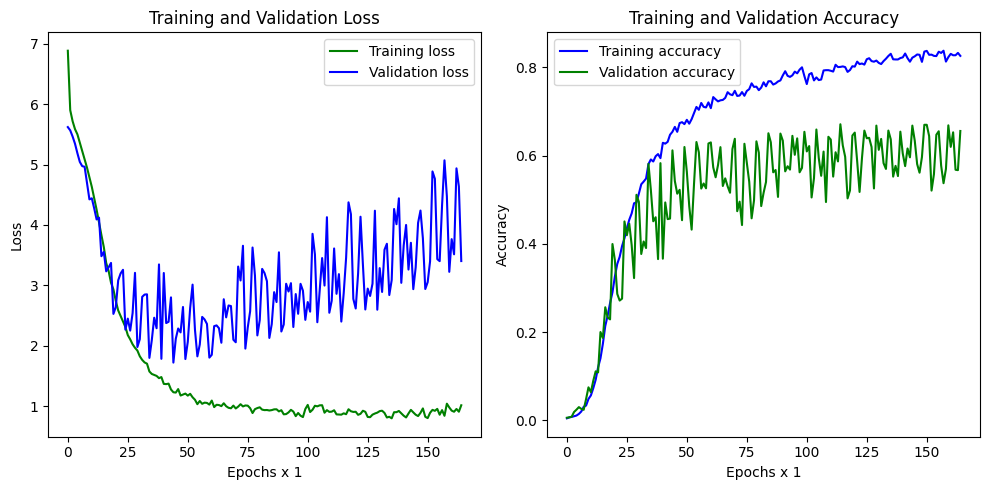

In [91]:
interval = 1
train_loss = hist.history['loss'][::interval]
val_loss = hist.history['val_loss'][::interval]
train_acc = hist.history['accuracy'][::interval]
val_acc = hist.history['val_accuracy'][::interval]

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel(f'Epochs x {interval}')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'b', label='Training accuracy')
plt.plot(val_acc, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel(f'Epochs x {interval}')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [92]:
name = '2-7(1)-acc'
model_filepath = '/kaggle/working/Kamel_Models'
os.makedirs(model_filepath, exist_ok=True)

model.save(model_filepath + f'/{name}.h5')
# model.save_weights(model_filepath + f'/{name}.h5')

# model.save(model_filepath + f'/{name}')
# converter = tf.lite.TFLiteConverter.from_saved_model(model_filepath + f'/{name}')
# converter.target_spec.supported_ops = [
#   tf.lite.OpsSet.TFLITE_BUILTINS,
#   tf.lite.OpsSet.SELECT_TF_OPS
# ]
# tflite_model = converter.convert()
# with open(model_filepath + f'/{name}.tflite', 'wb') as f:
#     f.write(tflite_model)

# shutil.rmtree(model_filepath + f'/{name}')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 2s 28ms/step


/tmp/ipykernel_34/3821455544.py:7: RuntimeWarning: invalid value encountered in divide
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


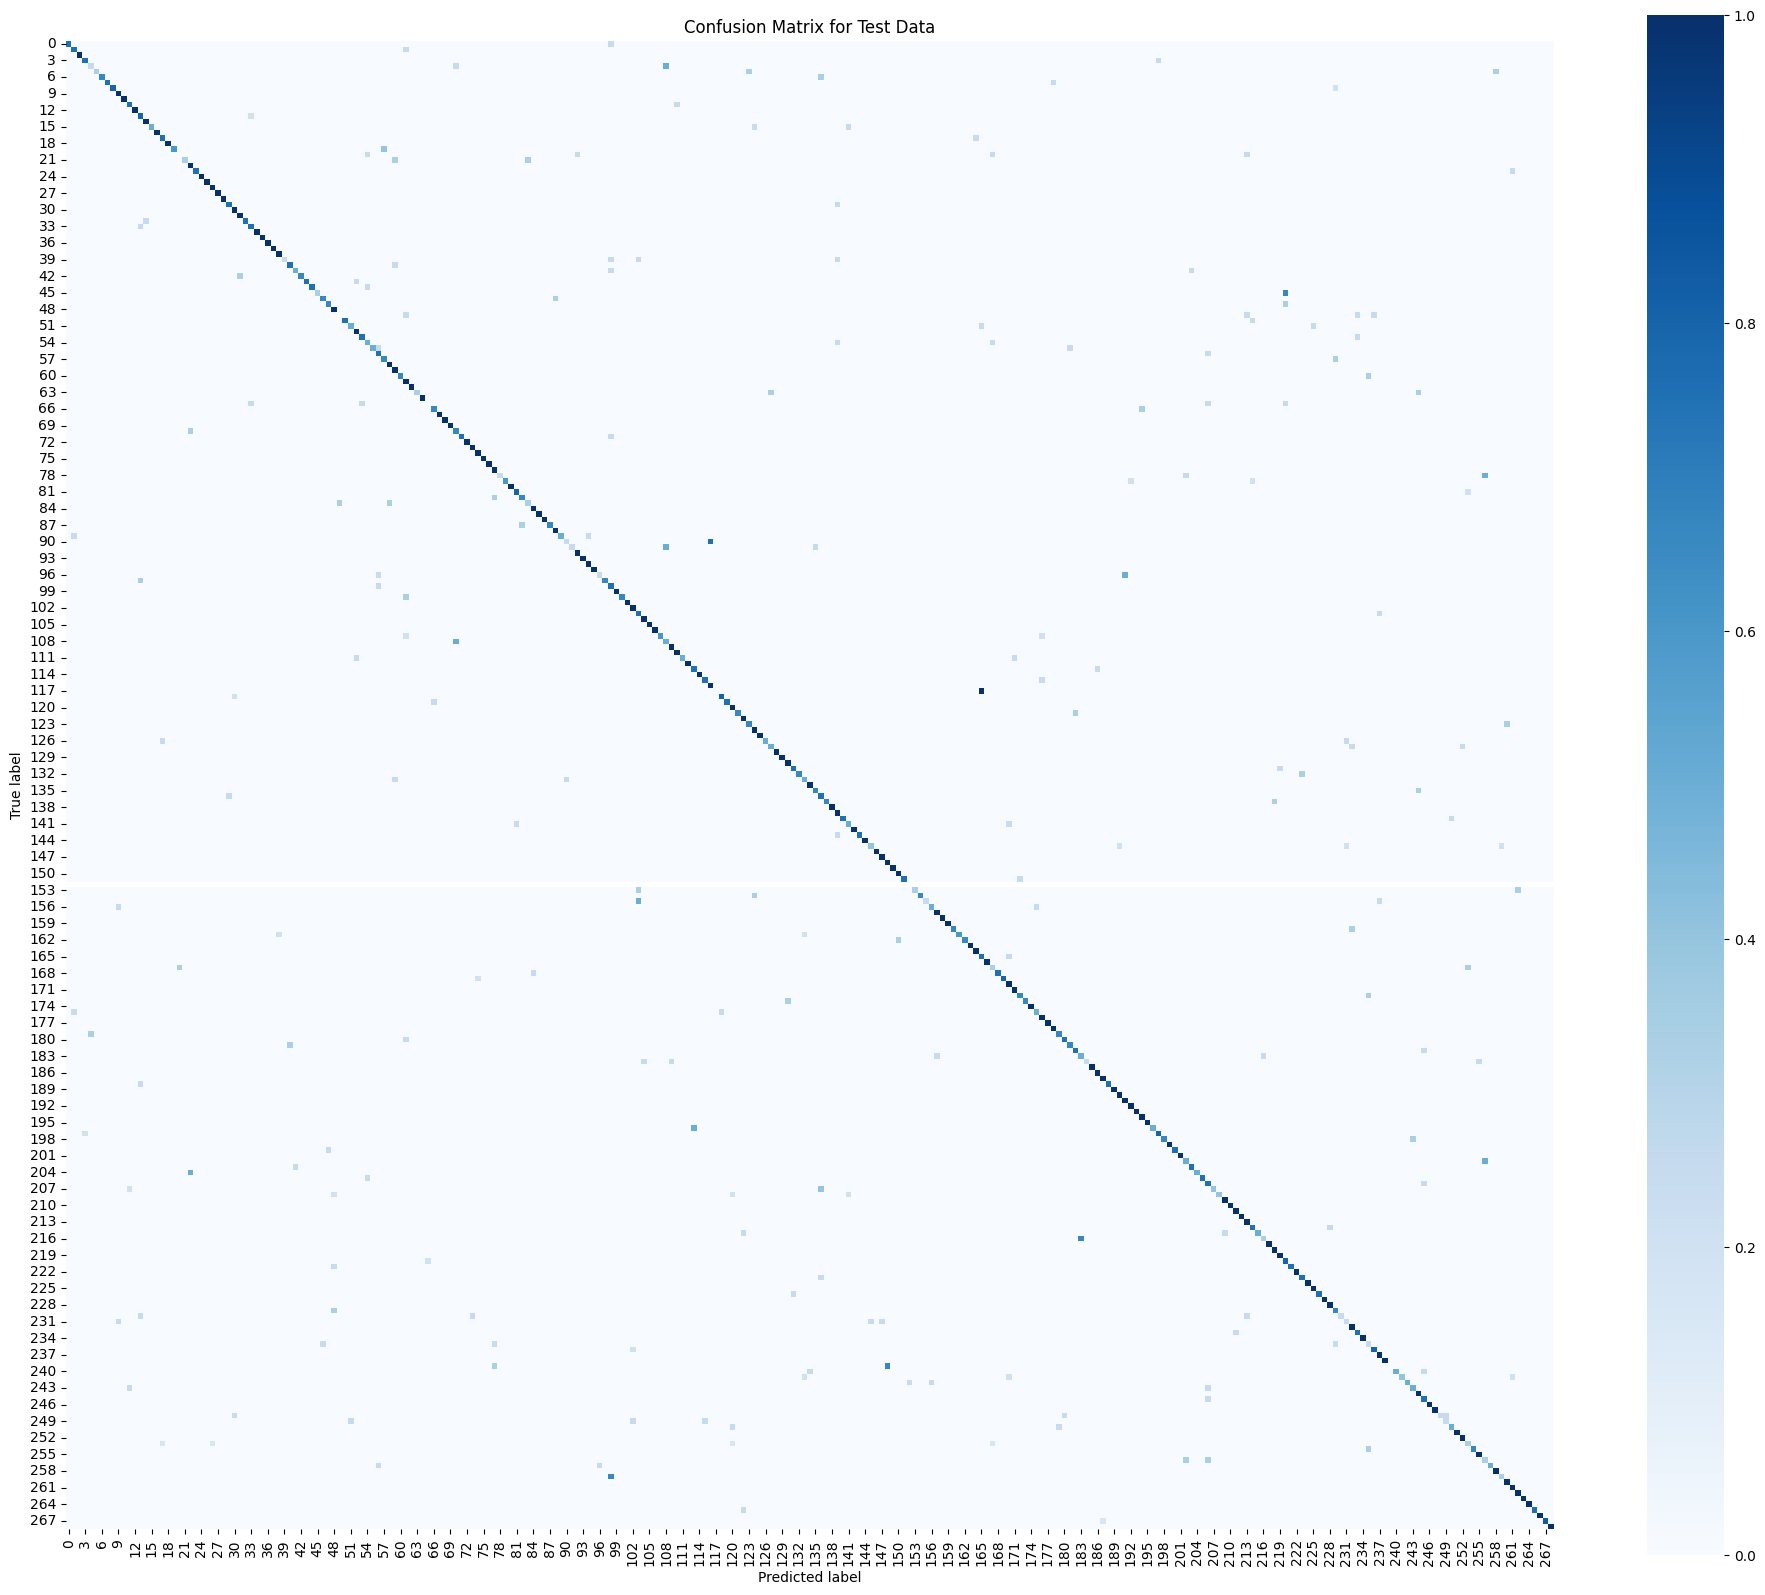

In [93]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred_probabilities = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probabilities, axis=1)
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(24, 20))
sns.heatmap(conf_matrix, cmap='Blues', annot=False, square=True)

plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
# del X_test, Y_test
# gc.collect()

---

<div id="Extras">
    
# **Extras**
    
<div align="right">
    <b><a href="#Introduction">Home</a></b>
</div>

In [94]:
model.load_weights('best_loss_weights.h5')

In [95]:
model.evaluate(X_val, Y_val)

103/103 [==============================] - 3s 24ms/step - loss: 1.7210 - accuracy: 0.6120


[1.7210438251495361, 0.6119585037231445]

In [96]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 27ms/step - loss: 1.2337 - accuracy: 0.6954


[1.2336561679840088, 0.6954365372657776]

In [97]:
name = '2-7(1)-loss'
model_filepath = '/kaggle/working/Kamel_Models'
os.makedirs(model_filepath, exist_ok=True)
model.save(model_filepath + f'/{name}.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


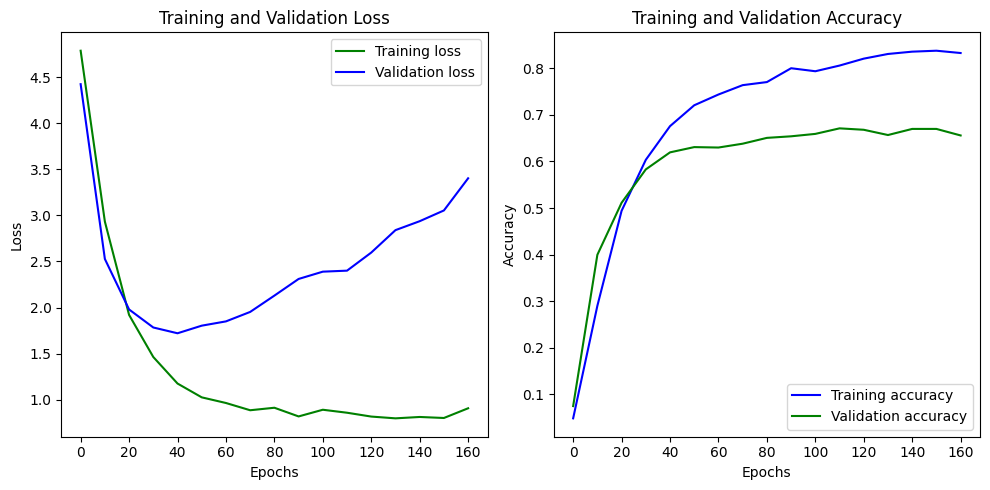

In [100]:
interval = 10

# Get the best loss and accuracy within each interval
train_loss = [np.min(hist.history['loss'][i:i+interval]) for i in range(0, len(hist.history['loss']), interval)]
val_loss = [np.min(hist.history['val_loss'][i:i+interval]) for i in range(0, len(hist.history['val_loss']), interval)]
train_acc = [np.max(hist.history['accuracy'][i:i+interval]) for i in range(0, len(hist.history['accuracy']), interval)]
val_acc = [np.max(hist.history['val_accuracy'][i:i+interval]) for i in range(0, len(hist.history['val_accuracy']), interval)]
x_axis_values = [i*interval for i in range(len(train_loss))]

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_axis_values, train_loss, 'g', label='Training loss')
plt.plot(x_axis_values, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(x_axis_values, train_acc, 'b', label='Training accuracy')
plt.plot(x_axis_values, val_acc, 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

32/32 [==============================] - 1s 25ms/step


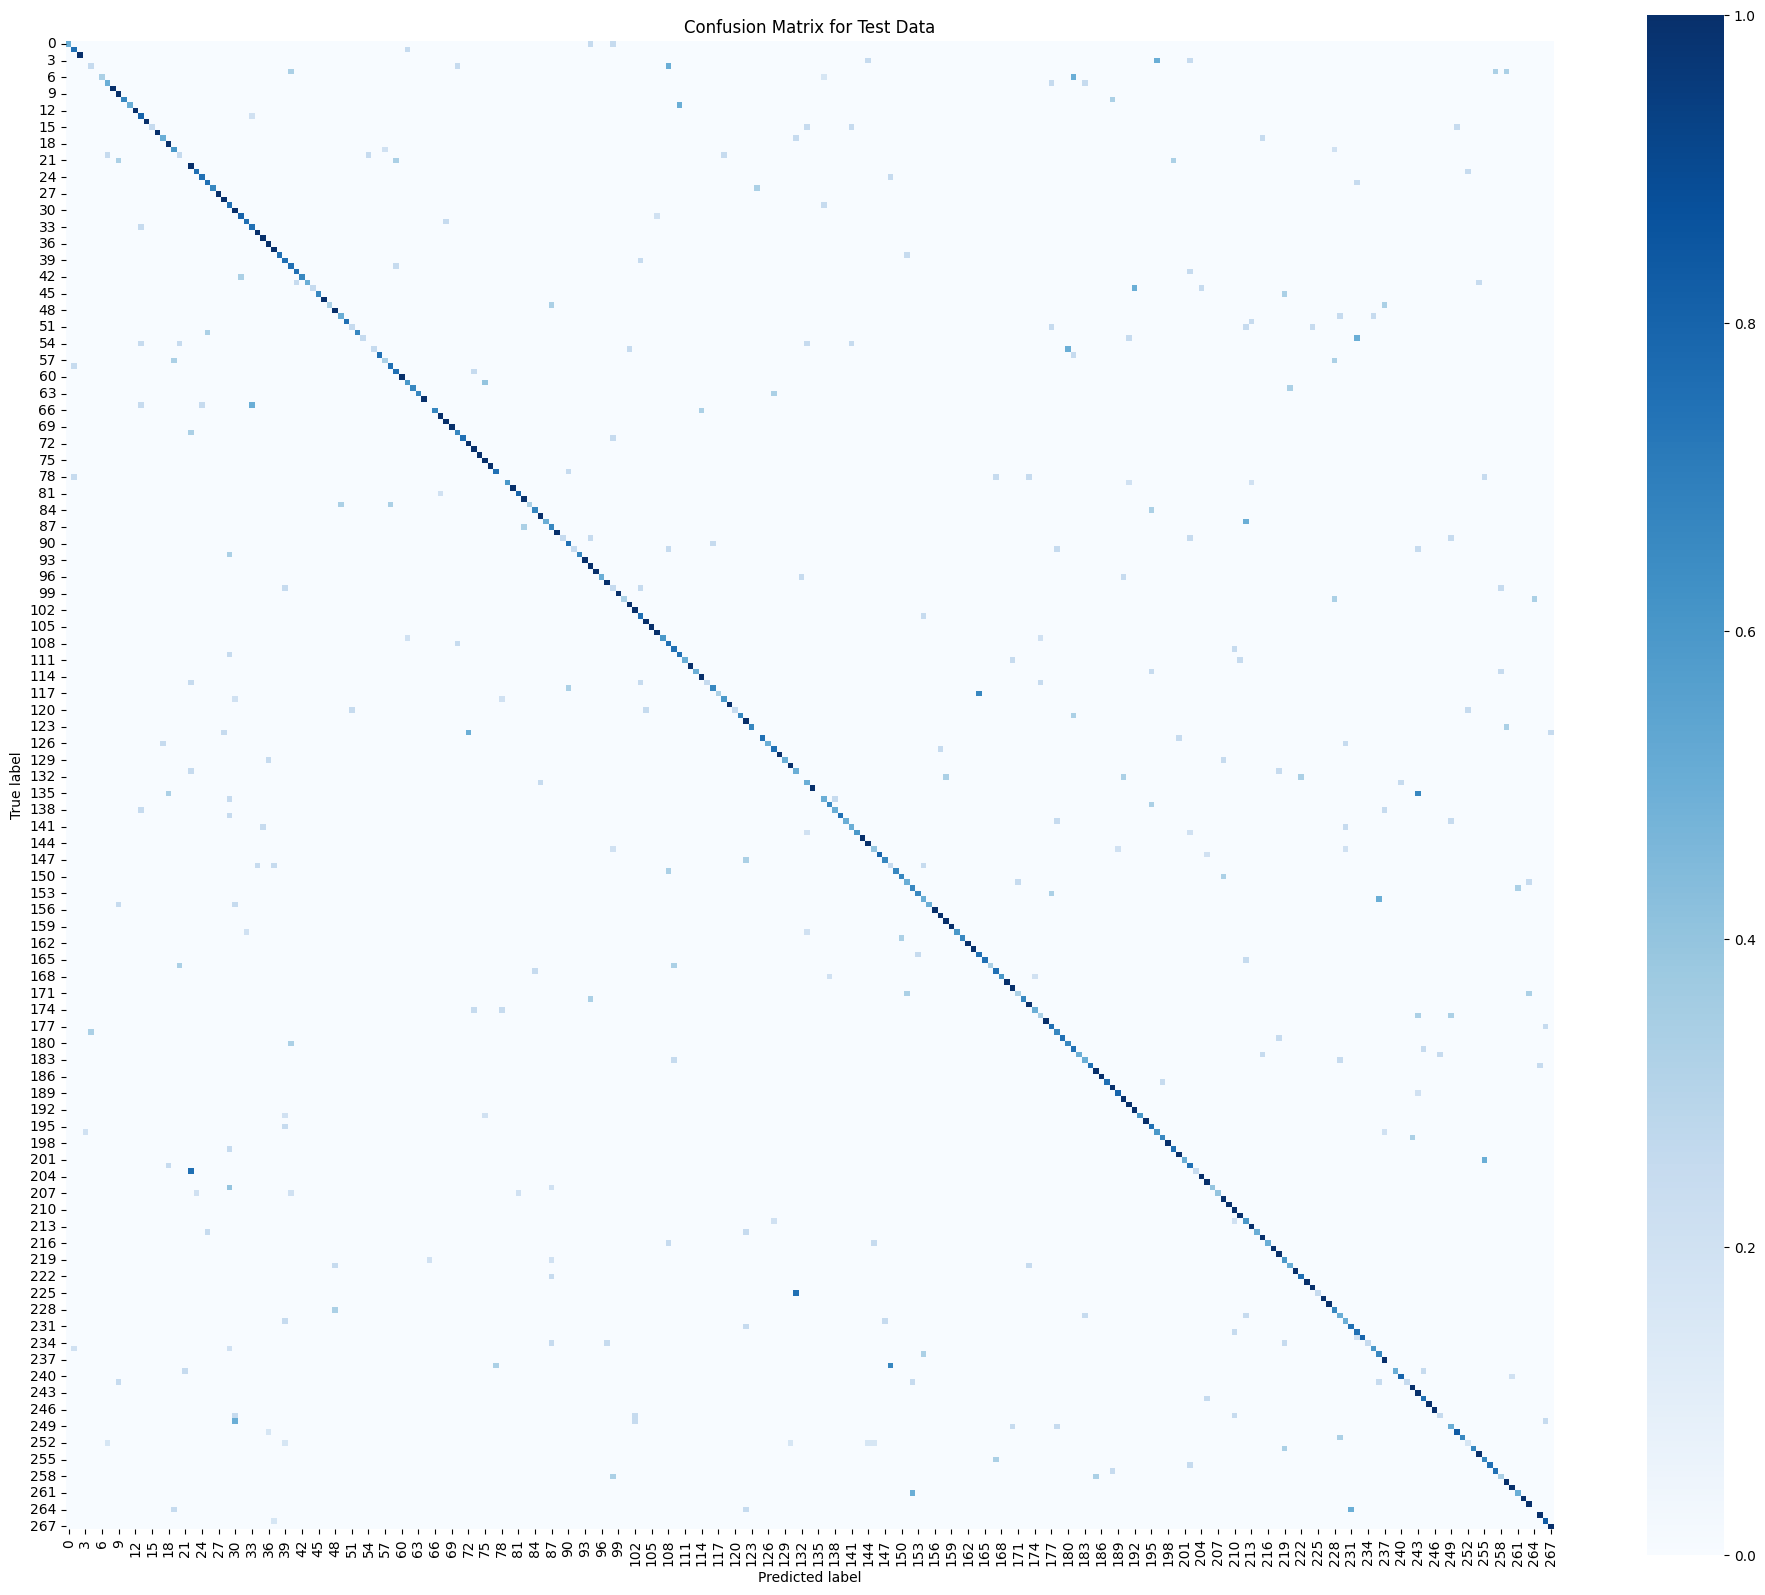

In [101]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred_probabilities = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probabilities, axis=1)
conf_matrix = confusion_matrix(Y_test, Y_pred)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(24, 20))
sns.heatmap(conf_matrix, cmap='Blues', annot=False, square=True)

plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

---